<a href="https://colab.research.google.com/github/DarshanDinni/learn_pytorch/blob/main/03_Computer_vision_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install patool kaggle torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 935.2 kB/s eta 0:00:00


In [2]:
# Importing the required libraries
import os
import random
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patoolib
import shutil
from tqdm.auto import tqdm

from PIL import Image

import torch
from torch import nn
from torchinfo import summary
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

**Set up google colab to download dataset from kaggle:**
https://saturncloud.io/blog/importing-datasets-from-kaggle-to-google-colab/

In [3]:
# Mount the google drive to the google colab
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set Kaggle Configuration: To direct Kaggle to the appropriate directory in Drive
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/DeepLearning/kaggle'

In [5]:
# Downloading the dataset
!kaggle datasets download -d harishkumardatalab/food-image-classification-dataset

 99% 1.67G/1.68G [00:15<00:00, 183MB/s]
100% 1.68G/1.68G [00:15<00:00, 119MB/s]


In [6]:
# Extract the downloaded zip file dataset
patoolib.extract_archive("food-image-classification-dataset.zip",outdir="/content")

INFO patool: Extracting food-image-classification-dataset.zip ...
INFO:patool:Extracting food-image-classification-dataset.zip ...
INFO patool: running /usr/bin/7z x -o/content -- food-image-classification-dataset.zip
INFO:patool:running /usr/bin/7z x -o/content -- food-image-classification-dataset.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... food-image-classification-dataset.zip extracted to `/content'.
INFO:patool:... food-image-classification-dataset.zip extracted to `/content'.


'/content'

**Understanding the data**

In [7]:
# Get the current working directory
CURRENT_DIRECTORY = os.getcwd()

# Default path for the dataset folder
DATASET_PATH = os.path.join(CURRENT_DIRECTORY, 'Food Classification dataset')

RANDOM_IMAGE_PATH = []

# Checking how many images we have in each food class
dataset_folder = os.listdir(DATASET_PATH)
for file in dataset_folder:
  SUB_FOLDER_PATH = os.path.join(DATASET_PATH, file)
  RANDOM_IMAGE_PATH.append(SUB_FOLDER_PATH + '/' + os.listdir(SUB_FOLDER_PATH)[0])
  print(f'{file}:  {len(os.listdir(SUB_FOLDER_PATH))} images')

paani_puri:  144 images
pav_bhaji:  305 images
sushi:  1000 images
Sandwich:  1500 images
dhokla:  245 images
kulfi:  214 images
Crispy Chicken:  1500 images
Taco:  1500 images
chicken_curry:  1000 images
masala_dosa:  273 images
kadai_paneer:  334 images
cheesecake:  1000 images
pakode:  269 images
fried_rice:  350 images
Baked Potato:  1500 images
burger:  331 images
chai:  344 images
chole_bhature:  376 images
Taquito:  1500 images
ice_cream:  1000 images
Fries:  1500 images
apple_pie:  1000 images
idli:  302 images
chapati:  327 images
pizza:  275 images
Hot Dog:  1548 images
butter_naan:  307 images
dal_makhani:  295 images
Donut:  1500 images
kaathi_rolls:  279 images
samosa:  244 images
jalebi:  288 images
omelette:  1000 images
momos:  323 images


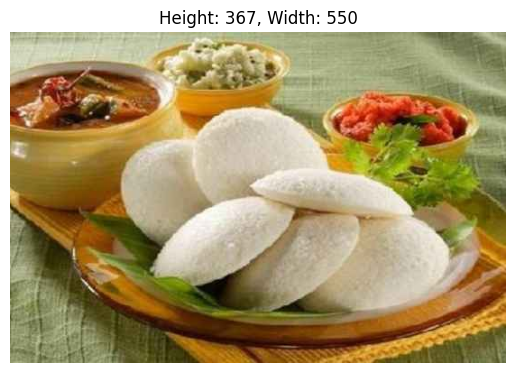

In [8]:
# Selecting any random image path
random_image = random.choice(RANDOM_IMAGE_PATH)
image = Image.open(random_image)

# Display the image
plt.title(f'Height: {image.height}, Width: {image.width}')
plt.imshow(image)
plt.axis('off')  # Optional: Turn off axis labels if you prefer
plt.show()

**Creating subset of the complete dataset**

In [9]:
def create_subset(train_sample_size, test_sample_size, class_size, original_dataset_path, working_directory):

  # Default path for train and test subset
  SUBSET_DATASET_PATH_TRAIN = working_directory + '/' + 'train'
  SUBSET_DATASET_PATH_TEST = working_directory + '/' + 'test'

  # Create the new subset directory path for train and test data if it doesn't exist
  os.makedirs(SUBSET_DATASET_PATH_TRAIN, exist_ok=True)
  os.makedirs(SUBSET_DATASET_PATH_TEST, exist_ok=True)

  # Get the list of all the food classes in the dataset
  food_folder = os.listdir(original_dataset_path)

  # Randomly select classes of food to create subset of data
  subset_folder = random.sample(food_folder, class_size)

  for images in range(len(subset_folder)):

    FOLDER_PATH = os.path.join(original_dataset_path, subset_folder[images])

    # Creating the path of different category of class for subset class
    SUBSET_FOLDER_PATH_TRAIN = os.path.join(SUBSET_DATASET_PATH_TRAIN, subset_folder[images])
    SUBSET_FOLDER_PATH_TEST = os.path.join(SUBSET_DATASET_PATH_TEST, subset_folder[images])

    # Create the subset directory for train and test sub-folders if it doesn't exist
    os.makedirs(SUBSET_FOLDER_PATH_TRAIN, exist_ok=True)
    os.makedirs(SUBSET_FOLDER_PATH_TEST, exist_ok=True)

    # Get the list of all the food image from the respective class
    food_images = os.listdir(FOLDER_PATH)

    # Randomly select images of food to create subset of respective class
    subset_image_train = random.sample(food_images, train_sample_size)
    subset_image_test = random.sample(food_images, test_sample_size)

    # Copy training data selected files from the original dataset to the subset dataset
    for file_name in subset_image_train:
        source_path = os.path.join(FOLDER_PATH, file_name)
        destination_path = os.path.join(SUBSET_FOLDER_PATH_TRAIN, file_name)
        shutil.copyfile(source_path, destination_path)

    # Copy testing data selected files from the original dataset to the subset dataset
    for file_name in subset_image_test:
        source_path = os.path.join(FOLDER_PATH, file_name)
        destination_path = os.path.join(SUBSET_FOLDER_PATH_TEST, file_name)
        shutil.copyfile(source_path, destination_path)

In [10]:
# Specify number of samples for each category of food
number_of_sample_train = 100
number_of_sample_test = 50

# Specify number of classes we will use
number_of_classes = 5  # total number of classes in the dataset are 34

# Create training and testing subset data
create_subset(number_of_sample_train, number_of_sample_test, number_of_classes, DATASET_PATH, CURRENT_DIRECTORY)

**Transforming the data**

As our dataset images are of different shapes we need to make all of them to the same shape before we start training.

In [11]:
# Creating all the base transforms to be applied on the data using pytorch.transforms
transform = transforms.Compose([
    # Resize to the standard shape of (64, 64)
    transforms.Resize(size=(64, 64)),
    # Just to create some random data we will flip the image horizontally with 50% probability to be flipped
    transforms.RandomHorizontalFlip(p=0.5),
    # Convert PIL or numpy array image to Tensor
    transforms.ToTensor()
])

**Visualize transformed data**

<Figure size 1000x800 with 0 Axes>

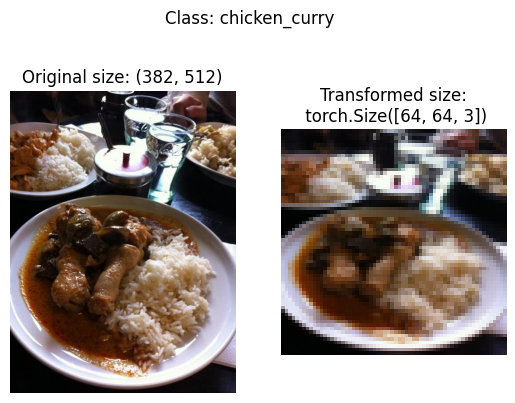

<Figure size 1000x800 with 0 Axes>

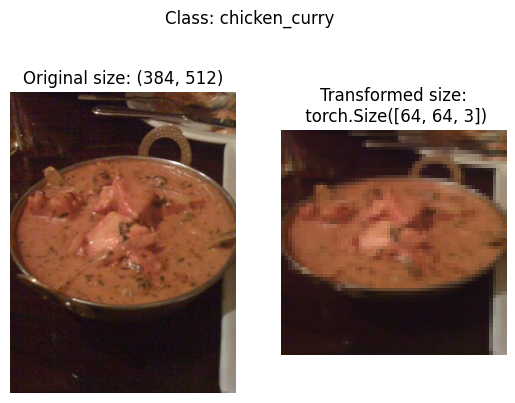

<Figure size 1000x800 with 0 Axes>

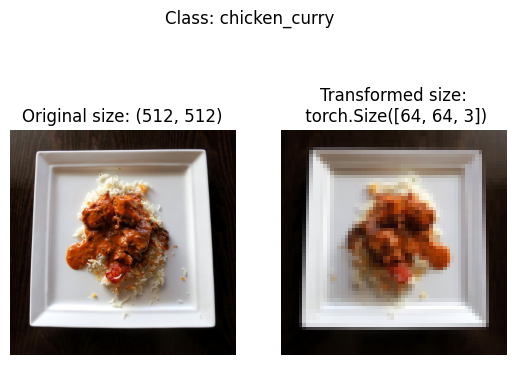

In [13]:
# Function to transform the image and plot it
def transformed_image(image_path, transform, sample_size, random_state=42):
  # Setup seed
  torch.manual_seed(random_state)

  food_images = os.listdir(image_path)

  # Select random sample of images
  sample_image = random.sample(food_images, k=sample_size)

  for image in sample_image:
    with Image.open(os.path.join(image_path, image)) as f:
      plt.figure(figsize=(10, 8))
      fig, ax = plt.subplots(1, 2)

      # Visualize the original image
      ax[0].imshow(f)
      ax[0].set_title(f"Original size: {f.size}")
      ax[0].axis("off")

      # Visualize the transformed image
      # Transform the image and change the shape from (C, H, W) -> (H, W, C) using permute
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed size:\n {transformed_image.shape}")
      ax[1].axis("off")

    plt.suptitle(f"Class: {image_path.split('/')[-1]}")
    plt.show()

TRAIN_DATASET_PATH = '/content/train/chicken_curry'
transformed_image(TRAIN_DATASET_PATH, transform=transform, sample_size=3)

In [14]:
# Convert complete train and test dataset to tensor using datasets.ImageFolder()

train_dir = os.path.join(CURRENT_DIRECTORY, 'train')
test_dir = os.path.join(CURRENT_DIRECTORY, 'test')

train_data = datasets.ImageFolder(root=train_dir, # training data directory path
                                  transform=transform, # the transform function for which we want the image to go through and transform
                                  target_transform=None
                                  )

test_data = datasets.ImageFolder(root=test_dir, # testing data directory path
                                 transform=transform # the transform function for which we want the image to go through and transform
                                 )

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 500
     Root location: /content/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 250
     Root location: /content/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
class_names = train_data.classes
class_names

['Sandwich', 'Taco', 'chicken_curry', 'kadai_paneer', 'pakode']

**Create train and test dataLoader**

In [16]:
# Creating training batches of data

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True
                              )

#  Creating testing batches of data
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False
                             )

In [17]:
img_custom, label_custom = next(iter(train_dataloader))
img_custom.shape, len(label_custom)

(torch.Size([32, 3, 64, 64]), 32)

**Version 0: Basline model**

In [18]:
# Basic transform for our model 0
simple_transform = transforms.Compose([transforms.Resize(size=(64, 64)), # Resize the image to base standard 64, 64
                                      transforms.ToTensor() # Convert image to tensors
                                      ])

# Get the train and test data and apply the simple transform
train_data_simple = datasets.ImageFolder(root=train_dir, # Path for the train data
                                         transform=simple_transform # Applying the simple transform on all the images in the train_dir
                                         )
test_data_simple = datasets.ImageFolder(root=test_dir,  # Path for the test data
                                         transform=simple_transform # Applying the simple transform on all the images in the test_dir
                                        )

# Convert the train and test data to data loaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=os.cpu_count()
                                     )

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=os.cpu_count()
                                     )

In [22]:
image, label = next(iter(train_dataloader_simple))
type(label)

torch.Tensor

In [23]:
# Create TinyVGG architecture
class TinyVGGV0(nn.Module):
  def __init__(self, input_units, hidden_units, output_units):
    super().__init__()

    # 1st convolution block
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_units, # Number of input units
                  out_channels = hidden_units, # This conv2d outputs "hidden_units" neurons
                  kernel_size = 3, # Set the filter size -> (3, 3)
                  stride = 1, # Number of pixels should a kernel move
                  padding = 0
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, # Number of units outputed by the previous layer
                  out_channels = hidden_units, # This conv2d outputs "hidden_units" neurons
                  kernel_size = 3, # Set the filter size -> (3, 3)
                  stride = 1, # Number of pixels should a kernel move
                  padding = 0
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, # Kernel size to perform max pooling
                      stride = 2, # Number of pixels should a kernel move
                      padding = 0
                      )
    )

    # 2nd convolution block
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, # Number of units outputed by the previous layer
                  out_channels = hidden_units, # This conv2d outputs "hidden_units" neurons
                  kernel_size = 3, # Set the filter size -> (3, 3)
                  stride = 1, # Number of pixels should a kernel move
                  padding = 0
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, # Number of units outputed by the previous layer
                  out_channels = hidden_units, # This conv2d outputs "hidden_units" neurons
                  kernel_size = 3, # Set the filter size -> (3, 3)
                  stride = 1, # Number of pixels should a kernel move
                  padding = 0
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, # Kernel size to perform max pooling
                      stride = 2, # Number of pixels should a kernel move
                      padding = 0
                      )
    )

    # Linear layer
    self.linear_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 13 * 13, # the dimension afters processing the above layers
                  out_features = output_units,
                  )
    )

  # Forward pass function for the data
  def forward(self, x: torch.Tensor):
    return self.linear_stack(self.conv_block_2(self.conv_block_1(x)))

In [24]:
# Set the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [76]:
INPUT_LAYER = 3 # Number of colour channel in the image is the number of input layer
OUTPUT_LAYER = 5 # Number of food classes
HIDDEN_LAYER = 32 # Number of hidden layers we want to have in the neural network

# Instantiate the model
model_0 = TinyVGGV0(INPUT_LAYER, HIDDEN_LAYER, OUTPUT_LAYER).to(device)

model_0

TinyVGGV0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5408, out_features=5, bias=True)
  )
)

In [77]:
summary(model_0, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGV0                                [32, 5]                   --
├─Sequential: 1-1                        [32, 32, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 32, 62, 62]          896
│    └─ReLU: 2-2                         [32, 32, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 32, 60, 60]          9,248
│    └─ReLU: 2-4                         [32, 32, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 32, 30, 30]          --
├─Sequential: 1-2                        [32, 32, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 32, 28, 28]          9,248
│    └─ReLU: 2-7                         [32, 32, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 32, 26, 26]          9,248
│    └─ReLU: 2-9                         [32, 32, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 32, 13, 13]          --
├─Seq

**Build the train and test loop**

In [78]:
def train_loop(model: nn.Module, # The model to train on
               data_loader: torch.utils.data.DataLoader, # Data for the model to train
               loss_function: nn.Module, # Function to calculate the loss
               optimizer: torch.optim.Optimizer, # Function to perform the optimization step
               accuracy_function, # Function to calculate the accracy of model
               device
               ):
  # Set the model to train mode
  model.train()

  train_loss, accuracy = 0, 0

  # Iterate through the batches and train the model
  for X, y in data_loader:
    # Set the data to respective device
    X, y = X.to(device), y.to(device)

    # Perform the forward pass
    y_pred = model(X)

    # Calculate the loss and accuracy over the batches
    loss = loss_function(y_pred, y)
    train_loss += loss.item()
    accuracy += accuracy_function(y, torch.argmax(torch.softmax(y_pred, dim=1), dim=1))

    # Set the optimizer to zero gradient
    optimizer.zero_grad()

    # Perform back propogation
    loss.backward()

    # Take step towards minimum loss
    optimizer.step()

  # Calculate the loss and accuracy over epochs
  train_loss = train_loss / len(data_loader)
  accuracy = accuracy / len(data_loader)

  return train_loss, accuracy


def test_loop(model: nn.Module, # The model to test on
               data_loader: DataLoader, # Data for the model to test
               loss_function: nn.Module, # Function to calculate the loss
               accuracy_function, # Function to perform the optimization step
               device=device
              ):
  # Set the model to enter the evaluation phase
  model.eval()

  loss, accuracy = 0, 0
  with torch.inference_mode():
    for X, y in data_loader:
      # Set the data to device
      X, y = X.to(device), y.to(device)

      # Perform the forward pass
      y_pred = model(X)

      # Calculate the loss and accuracy
      loss += loss_function(y_pred, y).item()
      accuracy += accuracy_function(y, torch.argmax(torch.softmax(y_pred, dim=1), dim=1))

    # Calculate the loss and accuracy over epochs
    loss = loss / len(data_loader)
    accuracy = accuracy / len(data_loader)

    return loss, accuracy

# Function which trains and tests the model and return the model result
def evaluate_model(model: nn.Module,
                   dataloader_train: torch.utils.data.DataLoader,
                   dataloader_test: torch.utils.data.DataLoader,
                   loss_function: nn.Module,
                   optimizer: torch.optim.Optimizer,
                   accuracy_function,
                   epochs: int
                   ):

  results = {
      "train_loss": [],
      "train_accuracy": [],
      "test_loss": [],
      "test_accuracy": []
  }

  for epoch in tqdm(range(epochs)):

    # Train the model
    train_loss, train_accuracy = train_loop(model_0, dataloader_train, loss_function, optimizer, accuracy_fn, device)

    # Test the model
    test_loss, test_accuracy = test_loop(model_0, dataloader_test, loss_function, accuracy_fn, device)

    # Print out the results
    print(f"Train loss: {train_loss: .4f}, Train accuracy: {train_accuracy: .4f}, Test loss: {test_loss: .4f}, Test accuracy: {test_accuracy: .4f}")

    # Append the results
    results["train_loss"].append(train_loss)
    results["train_accuracy"].append(train_accuracy)
    results["test_loss"].append(test_loss)
    results["test_accuracy"].append(test_accuracy)

  return results

In [79]:
# As we have multiclass classification problem so we need CrossEntropyLoss as loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(model_0.parameters(), lr=LEARNING_RATE)

In [80]:
# Calculate accuracy metrics
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [81]:
# Evaluate the model
# Number of epochs to train the model
EPOCHS = 10
model_0_results = evaluate_model(model_0, train_dataloader_simple, test_dataloader_simple, loss_function, optimizer, accuracy_fn, EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Train loss:  1.6018, Train accuracy:  22.2266, Test loss:  1.5639, Test accuracy:  27.8846
Train loss:  1.5135, Train accuracy:  31.8750, Test loss:  1.4468, Test accuracy:  33.5337
Train loss:  1.3687, Train accuracy:  39.6094, Test loss:  1.4444, Test accuracy:  31.2200
Train loss:  1.3656, Train accuracy:  39.6875, Test loss:  1.4052, Test accuracy:  34.6755
Train loss:  1.3233, Train accuracy:  44.9219, Test loss:  1.4350, Test accuracy:  37.5300
Train loss:  1.2512, Train accuracy:  47.7734, Test loss:  1.4266, Test accuracy:  34.4050
Train loss:  1.2893, Train accuracy:  45.9375, Test loss:  1.3674, Test accuracy:  36.8389
Train loss:  1.2586, Train accuracy:  50.6250, Test loss:  1.3594, Test accuracy:  42.1274
Train loss:  1.1723, Train accuracy:  51.7578, Test loss:  1.3891, Test accuracy:  37.9808
Train loss:  1.1446, Train accuracy:  52.8125, Test loss:  1.3614, Test accuracy:  40.4447


In [82]:
model_0_results

{'train_loss': [1.6017801389098167,
  1.5135362967848778,
  1.3686516508460045,
  1.3655834570527077,
  1.3233273923397064,
  1.2511803843080997,
  1.2892988435924053,
  1.2585843652486801,
  1.172263354063034,
  1.1445549093186855],
 'train_accuracy': [22.2265625,
  31.875,
  39.609375,
  39.6875,
  44.921875,
  47.7734375,
  45.9375,
  50.625,
  51.7578125,
  52.8125],
 'test_loss': [1.5639132857322693,
  1.4468411356210709,
  1.4444045573472977,
  1.4051646888256073,
  1.4349512457847595,
  1.4266077727079391,
  1.3673686981201172,
  1.3594313263893127,
  1.389104887843132,
  1.3614073693752289],
 'test_accuracy': [27.884615384615383,
  33.53365384615385,
  31.219951923076923,
  34.67548076923077,
  37.53004807692308,
  34.40504807692308,
  36.83894230769231,
  42.12740384615385,
  37.98076923076923,
  40.44471153846154]}